# Different Loss Functions for Classification

The performance of a classifier is often evaluated in terms of accuracy. To trace back how much each feature contributes to the overall performance e.g., the improvement in accuracy from a feature, SAGE implements the zero-one loss.

Recall (or [look up](https://arxiv.org/pdf/1811.12808.pdf)) that accuracy $\operatorname{ACC}(\cdot)$ can be defined as:
$$
\operatorname{ACC} = 1 - \frac{1}{n} \sum_{i=1}^n L(\hat{y}_i, y_i)
$$
whereby $L(\cdot)$ is the zero-one loss given by:
$$
L(\hat{y}_i, y_i) = \mathbb{I}\left(y_{i}\neq \hat{y}_{i}\right).
$$

Thus, there exists a direct link between accuracy and zero-one loss. Put it simply, improvements in zero-one loss (decrease) directly relates to improvements in accuracy. 

Conventiently, SAGE values estimated using the zero-one loss can be interpreted as the change in zero-one loss over a naïve prediction or change in accuracy over a naïve prediction.

## Load Data

<https://archive.ics.uci.edu/ml/datasets/South+German+Credit+%28UPDATE%29>

In [1]:
import numpy as np
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, log_loss, zero_one_loss

import sage

/home/markus/workdir/sage/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
df = sage.datasets.credit()

# Feature names and categorical columns (for CatBoost model)
feature_names = df.columns.tolist()
categorical_features = [
    "Credit History",
    "Purpose",
    "Credit Amount",
    "Savings Account/Bonds",
    "Employment Since",
    "Personal Status",
    "Debtors/Guarantors",
    "Property Type",
    "Other Installment Plans",
    "Housing Ownership",
    "Job",
    "Telephone",
    "Foreign Worker",
]

df[categorical_features] = df[categorical_features].astype("category")

In [3]:
# Shuffle + split into 60 % train set, 10 % val set, and 10 % test set
train, val, test = np.split(df.sample(frac=1), [int(0.8 * len(df)), int(0.9 * len(df))])

y_train, y_val, y_test = (
    train["Good Customer"],
    val["Good Customer"],
    test["Good Customer"],
)
X_train, X_val, X_test = (
    train.drop(columns="Good Customer"),
    val.drop(columns="Good Customer"),
    test.drop(columns="Good Customer"),
)

/home/markus/workdir/sage/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


## Train model

Calculate the accuracy, cross-entropy loss, and zero-one loss of naïve prediction. The `DummyClassifier` predicts the most-frequent class passed to `fit()` when `predict()` is called and the empirical class-prior distribution when `predict_proba()` is called. See [`docs`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn-dummy-dummyclassifier).

In [4]:
naive_model = DummyClassifier(strategy="prior")
naive_model.fit(X_train, y_train)

DummyClassifier()

In [5]:
base_acc = accuracy_score(y_test, naive_model.predict(X_test))
base_zero_one_loss = zero_one_loss(y_test, naive_model.predict(X_test))
base_log_loss = log_loss(y_test, naive_model.predict_proba(X_test))

print(f"Naïve accuracy = {base_acc:.3f}")
print(f"Naïve zero-one = {base_zero_one_loss:.3f}")
print(f"Naïve cross-entropy = {base_log_loss:.3f}")

Naïve accuracy = 0.670
Naïve zero-one = 0.330
Naïve cross-entropy = 0.637


In [6]:
catboost_model = CatBoostClassifier(iterations=100, learning_rate=0.3, depth=3)

catboost_model = catboost_model.fit(
    X_train,
    y_train,
    eval_set=(X_val, y_val),
    cat_features=categorical_features,
    verbose=False,
)

In [7]:
catboost_acc = accuracy_score(y_test, catboost_model.predict(X_test))
catboost_zero_one_loss = zero_one_loss(y_test, catboost_model.predict(X_test))
catboost_log_loss = log_loss(y_test, catboost_model.predict_proba(X_test))
print(f"Catboost accuracy = {catboost_acc:.3f}")
print(f"Catboost zero-one = {catboost_zero_one_loss:.3f}")
print(f"Catboost cross-entropy = {catboost_log_loss:.3f}")

assert catboost_zero_one_loss == 1 - catboost_acc

Catboost accuracy = 0.760
Catboost zero-one = 0.240
Catboost cross-entropy = 0.530


## Calculate importance
### Zero-one Loss

In [17]:
imputer = sage.MarginalImputer(catboost_model, X_train[:128])
estimator = sage.PermutationEstimator(imputer, "zero one", n_jobs=-1)
sage_values = estimator(X_test.to_numpy(), y_test.to_numpy())

PermutationEstimator will use 8 jobs


100%|██████████| 1/1 [05:44<00:00, 344.23s/it]     


In [18]:
np.testing.assert_approx_equal(
    catboost_zero_one_loss - base_zero_one_loss,
    -np.sum(sage_values.values),
    significant=2,
)
np.testing.assert_approx_equal(
    catboost_acc - base_acc, np.sum(sage_values.values), significant=2
)

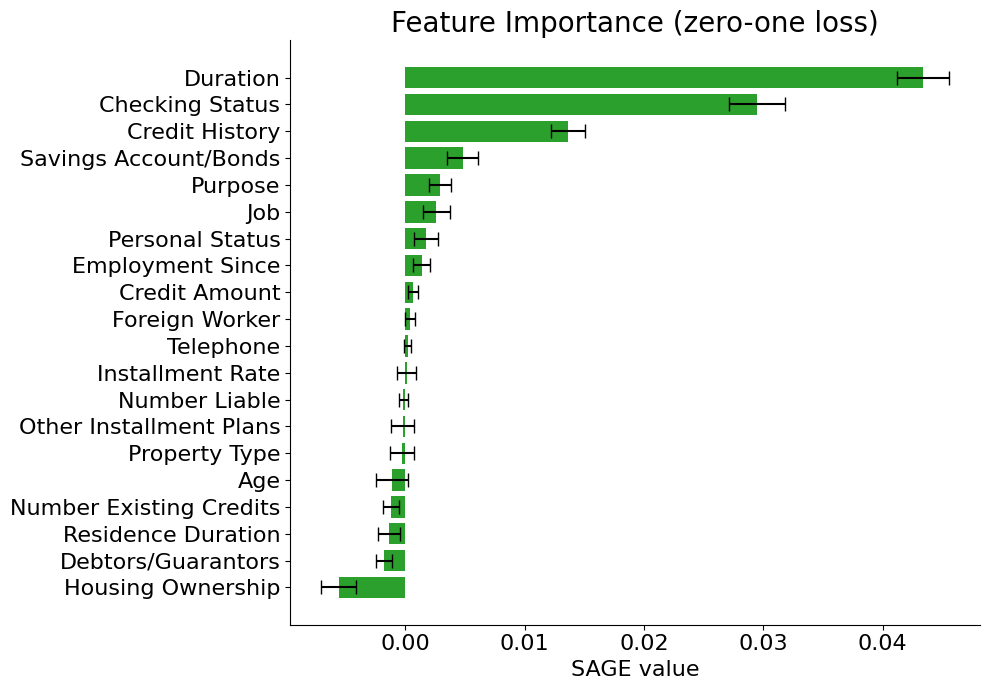

In [20]:
sage_values.plot(feature_names, title="Feature Importance (zero-one loss)")

### Cross-Entropy Loss

In [21]:
imputer = sage.MarginalImputer(catboost_model, X_train[:128])
estimator = sage.PermutationEstimator(imputer, "cross entropy", n_jobs=-1)
sage_values = estimator(X_test.to_numpy(), y_test.to_numpy())

PermutationEstimator will use 8 jobs


100%|██████████| 1/1 [01:42<00:00, 102.95s/it]    


In [22]:
np.testing.assert_approx_equal(
    catboost_log_loss - base_log_loss, -np.sum(sage_values.values), significant=2
)

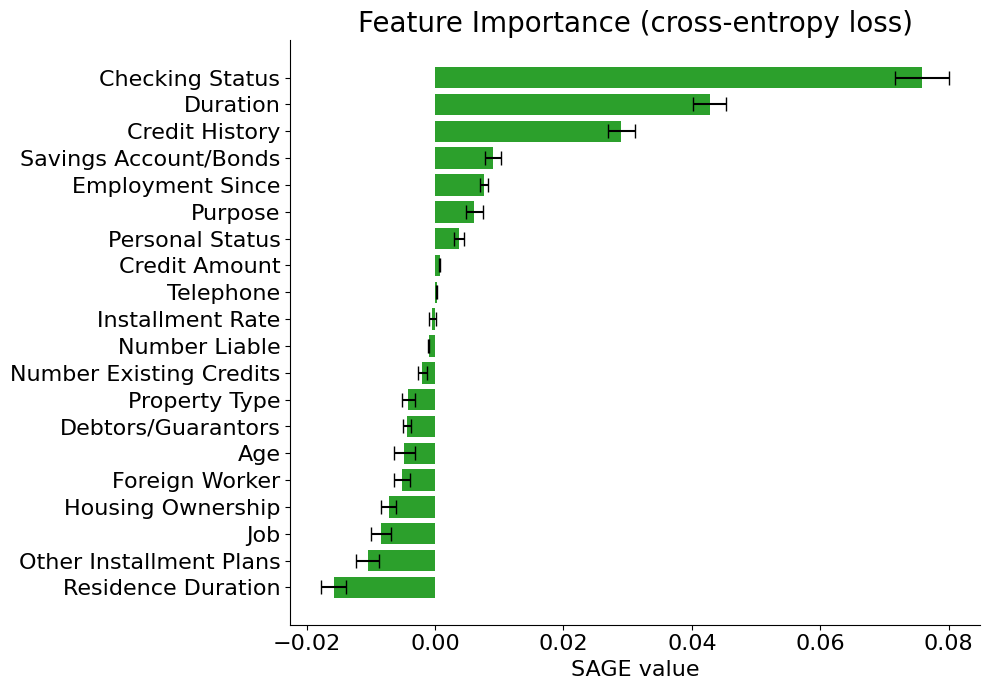

In [23]:
sage_values.plot(feature_names, title="Feature Importance (cross-entropy loss)")